In [1]:
print('test')

test


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [5]:
DATASET_ID = 'bengalese_finch_sober'

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [8]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=1,
    mel_upper_edge_hertz=1995,
    butter_lowcut = 1,
    butter_highcut = 1995,
    ref_level_db = 20,
    min_level_db = -25,
    win_length_ms = 100,
    hop_length_ms = 20,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.25, "offset": 1e-10},
    reduce_noise=True,
    noise_reduce_kwargs = {"n_std_thresh": 1.5, "prop_decrease":0.9}

)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s


[Parallel(n_jobs=-1)]: Done 2663 out of 2663 | elapsed:    6.0s finished


In [106]:
n_sylls = [len(dataset.data_files[i].data['indvs'][list(dataset.data_files[i].data['indvs'].keys())[0]]['syllables']['start_times']) for i in list(dataset.data_files.keys())]

In [107]:
#file_lens = [dataset.data_files[i].data['length_s'] for i in list(dataset.data_files.keys())]
np.max(n_sylls)

398

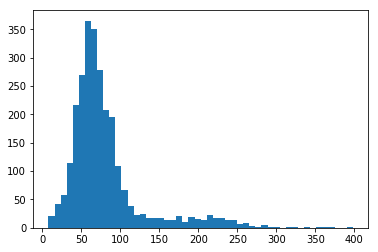

In [108]:
plt.hist(n_sylls, bins = 50);

In [110]:
key = list(dataset.data_files.keys())[np.argsort(n_sylls)[::-1][0]]
key

'bl26lb16_200412_1047.-32700'

In [122]:
### parameters
n_fft=128
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-70
silence_threshold = 0.01
min_silence_for_spec=0.1
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
spectral_range = [500, 16000]

In [123]:
wf = dataset.data_files[key].data['wav_loc']

In [124]:
import librosa
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [125]:
data, rate = librosa.core.load(wf, sr=None)
len(data)/rate

61.4939375

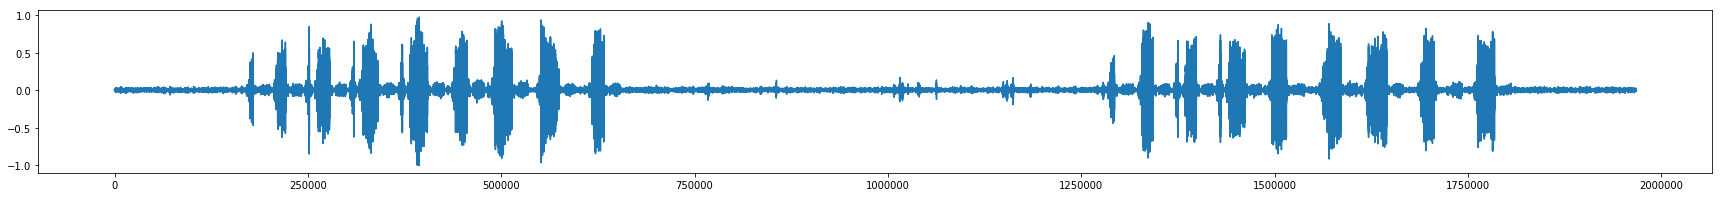

In [126]:
fig, ax = plt.subplots(figsize=(30,3))
ax.plot(data)

In [127]:
#data = data[:rate*20]

In [128]:
data = butter_bandpass_filter(data, 500, 15999, rate, order = 2)

In [129]:
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
    silence_threshold = silence_threshold,
    verbose=True,
    spectral_range = spectral_range,
    min_syllable_length_s = min_syllable_length_s
    
)





  0%|          | 0/6 [00:00<?, ?it/s]



 17%|█▋        | 1/6 [00:00<00:03,  1.41it/s]

longest silence 0.020000000000000018
longest vocalization 0.5039999999999978
Current min_level_db: -70






 33%|███▎      | 2/6 [00:01<00:02,  1.54it/s]

longest silence 0.08100000000000307
longest vocalization 0.4529999999999994
Current min_level_db: -65


longest silence 1.4149999999999991
longest vocalization 0.22300000000000253


In [134]:
results.keys()

dict_keys(['spec', 'vocal_envelope', 'min_level_db', 'onsets', 'offsets'])

In [136]:
len(results['onsets'])

453

In [130]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [131]:
figsize = (200,4)

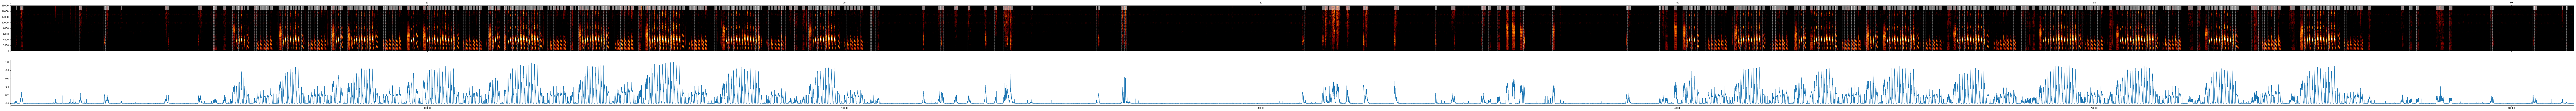

In [132]:
fig, axs = plt.subplots(nrows = 2, figsize=(figsize[0], figsize[1]*2))
plot_spec(results['spec'], fig, axs[0], rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
axs[1].plot(results['vocal_envelope'])
#axs[1].plot(results['vocal_envelope'] > silence_threshold)
axs[1].set_xlim([0, len(results['vocal_envelope'])])

ylmin, ylmax = (axs[0].get_ylim())
ysize = (ylmax - ylmin)*.1
ymin = ylmax- ysize

patches = []
for onset, offset in zip(results['onsets'], results['offsets']):
    axs[0].axvline(onset, color = '#FFFFFF', ls="dashed", lw=0.5)
    patches.append(Rectangle(xy=(onset, ymin), width = offset-onset, height = ysize))

collection = PatchCollection(patches, color='white', alpha=0.5)
axs[0].add_collection(collection);